In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("huseyincavus/deepstroke")

print("Path to dataset files:", path)

/home/bacon/DeepStrokeGradio/DSGRD/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resuming download from 1048576 bytes (1652285256 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/huseyincavus/deepstroke?dataset_version_number=1 (1048576/1653333832) bytes left.


100%|██████████| 1.54G/1.54G [03:32<00:00, 7.77MB/s]

Extracting files...


Path to dataset files: /home/bacon/.cache/kagglehub/datasets/huseyincavus/deepstroke/versions/1


In [ ]:
!mv /home/bacon/.cache/kagglehub/datasets/huseyincavus/deepstroke/versions/1/* /home/bacon/DeepStrokeGradio/

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models.resnet import Bottleneck
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths
model_path = '/home/bacon/DeepStrokeGradio/DSGRD/best_seresnext50_model.pth'
val_images_dir = '/home/bacon/DeepStrokeGradio/DeepStroke1_Data/XTR Val'
labels_file = '/home/bacon/DeepStrokeGradio/DeepStroke1_Data/XTR Val labels.txt'

# SE-ResNeXt50 Model with correct SE implementation (matching training code)
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEBottleneck(Bottleneck):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, se_reduction=16):
        super(SEBottleneck, self).__init__(inplanes, planes, stride, downsample,
                                         groups, base_width, dilation, norm_layer)
        self.se = SELayer(planes * self.expansion, reduction=se_reduction)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

def get_seresnext50(num_classes=1, se_reduction=16):
    """Create SE-ResNeXt50 model matching the training architecture"""
    model = models.resnext50_32x4d(pretrained=True)
    base_width = model.base_width

    def replace_bottlenecks(module, se_reduction_ratio, base_width):
        for name, child_module in module.named_children():
            if isinstance(child_module, Bottleneck):
                inplanes = child_module.conv1.in_channels
                planes = child_module.conv3.out_channels // child_module.expansion
                stride = child_module.stride
                downsample = child_module.downsample
                groups = child_module.conv2.groups
                dilation = child_module.conv2.dilation[0]

                new_bottleneck = SEBottleneck(
                    inplanes=inplanes,
                    planes=planes,
                    stride=stride,
                    downsample=downsample,
                    groups=groups,
                    base_width=base_width,
                    dilation=dilation,
                    se_reduction=se_reduction_ratio
                )

                new_bottleneck.load_state_dict(child_module.state_dict(), strict=False)
                setattr(module, name, new_bottleneck)
            else:
                replace_bottlenecks(child_module, se_reduction_ratio, base_width)

    replace_bottlenecks(model, se_reduction, base_width)

    # Replace final layer for binary classification (single output)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

# Create model and load weights
print("Loading model...")
model = get_seresnext50(num_classes=1, se_reduction=16)

# Load checkpoint and extract model state dict
checkpoint = torch.load(model_path, map_location=device)
print(f"Checkpoint keys: {list(checkpoint.keys())}")

# Load the model state dict from checkpoint
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']

    # Remove 'module.' prefix if present (from DataParallel)
    if any(key.startswith('module.') for key in state_dict.keys()):
        state_dict = {key.replace('module.', ''): value for key, value in state_dict.items()}
        print("Removed 'module.' prefix from state dict keys")

    # Load state dict with strict=False to handle missing keys
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

    if missing_keys:
        print(f"Missing keys: {len(missing_keys)} keys")
        print(f"First few missing keys: {missing_keys[:5]}")
    if unexpected_keys:
        print(f"Unexpected keys: {len(unexpected_keys)} keys")
        print(f"First few unexpected keys: {unexpected_keys[:5]}")

    print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
    if 'val_loss' in checkpoint:
        print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
    if 'config' in checkpoint:
        config = checkpoint['config']
        print(f"Model config: {config}")
else:
    # If it's just the model state dict
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()
print("Model loaded successfully!")

# Define preprocessing transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Model and transforms ready for evaluation!")

Using device: cuda
Loading model...
Checkpoint keys: ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'epoch', 'val_loss', 'history', 'config']
Removed 'module.' prefix from state dict keys
Loaded model from epoch 17
Best validation loss: 0.0045
Model config: {'learning_rate': 0.0004, 'weight_decay': 0.0001, 'batch_size': 128, 'se_reduction_ratio': 16}
Model loaded successfully!
Model and transforms ready for evaluation!
Checkpoint keys: ['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'epoch', 'val_loss', 'history', 'config']
Removed 'module.' prefix from state dict keys
Loaded model from epoch 17
Best validation loss: 0.0045
Model config: {'learning_rate': 0.0004, 'weight_decay': 0.0001, 'batch_size': 128, 'se_reduction_ratio': 16}
Model loaded successfully!
Model and transforms ready for evaluation!


In [ ]:
# Load and parse labels
print("Loading validation labels...")
labels_df = pd.read_csv(labels_file, sep='\t')
print(f"Loaded {len(labels_df)} validation samples")
print(f"Label distribution: {labels_df['İnme Var mı?'].value_counts().to_dict()}")

# Create mapping from image ID to label
label_map = dict(zip(labels_df['Image Id'].astype(str), labels_df['İnme Var mı?']))

# Get list of available validation images
val_images_path = Path(val_images_dir)
image_files = list(val_images_path.glob('*.png'))
print(f"Found {len(image_files)} validation images")

# Filter images that have corresponding labels
valid_images = []
valid_labels = []

for img_file in image_files:
    img_id = img_file.stem  # Get filename without extension
    if img_id in label_map:
        valid_images.append(img_file)
        valid_labels.append(label_map[img_id])

print(f"Found {len(valid_images)} images with corresponding labels")
print(f"Final label distribution: {pd.Series(valid_labels).value_counts().to_dict()}")
print(f"Class distribution: No stroke: {valid_labels.count(0)}, Stroke: {valid_labels.count(1)}")

Loading validation labels...
Loaded 200 validation samples
Label distribution: {0: 130, 1: 70}
Found 200 validation images
Found 200 images with corresponding labels
Final label distribution: {0: 130, 1: 70}
Class distribution: No stroke: 130, Stroke: 70


In [ ]:
def evaluate_model(model, image_paths, true_labels, transform, device, batch_size=32):
    """Evaluate model on validation set"""
    model.eval()
    predictions = []
    probabilities = []

    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Evaluating"):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []

            # Load and preprocess batch of images
            for img_path in batch_paths:
                try:
                    image = Image.open(img_path).convert('RGB')
                    image_tensor = transform(image)
                    batch_images.append(image_tensor)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue

            if batch_images:
                # Stack images into batch tensor
                batch_tensor = torch.stack(batch_images).to(device)

                # Get predictions (single output with sigmoid)
                outputs = model(batch_tensor)
                probs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid and remove extra dimension

                # Convert to binary predictions (threshold at 0.5)
                preds = (probs > 0.5).float()

                predictions.extend(preds.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())

    return np.array(predictions), np.array(probabilities)

print("Starting model evaluation...")
predicted_labels, predicted_probs = evaluate_model(
    model, valid_images, valid_labels, transform, device
)

print(f"Evaluation completed! Got {len(predicted_labels)} predictions")

Starting model evaluation...


Evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

Evaluation completed! Got 200 predictions


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(valid_labels, predicted_labels)
precision = precision_score(valid_labels, predicted_labels, average='weighted')
recall = recall_score(valid_labels, predicted_labels, average='weighted')
f1 = f1_score(valid_labels, predicted_labels, average='weighted')

# Calculate per-class metrics
precision_per_class = precision_score(valid_labels, predicted_labels, average=None)
recall_per_class = recall_score(valid_labels, predicted_labels, average=None)
f1_per_class = f1_score(valid_labels, predicted_labels, average=None)

print("=" * 60)
print("EXTERNAL VALIDATION RESULTS")
print("=" * 60)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print()
print("Per-Class Metrics:")
print(f"Class 0 (No Stroke) - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1: {f1_per_class[0]:.4f}")
print(f"Class 1 (Stroke) - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1: {f1_per_class[1]:.4f}")
print()

# Detailed classification report
print("Detailed Classification Report:")
print(classification_report(valid_labels, predicted_labels, target_names=['No Stroke', 'Stroke']))

# Confusion Matrix
cm = confusion_matrix(valid_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

EXTERNAL VALIDATION RESULTS
Overall Accuracy: 0.9550
Weighted Precision: 0.9550
Weighted Recall: 0.9550
Weighted F1-Score: 0.9548

Per-Class Metrics:
Class 0 (No Stroke) - Precision: 0.9549, Recall: 0.9769, F1: 0.9658
Class 1 (Stroke) - Precision: 0.9552, Recall: 0.9143, F1: 0.9343

Detailed Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      0.98      0.97       130
      Stroke       0.96      0.91      0.93        70

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200


Confusion Matrix:
[[127   3]
 [  6  64]]


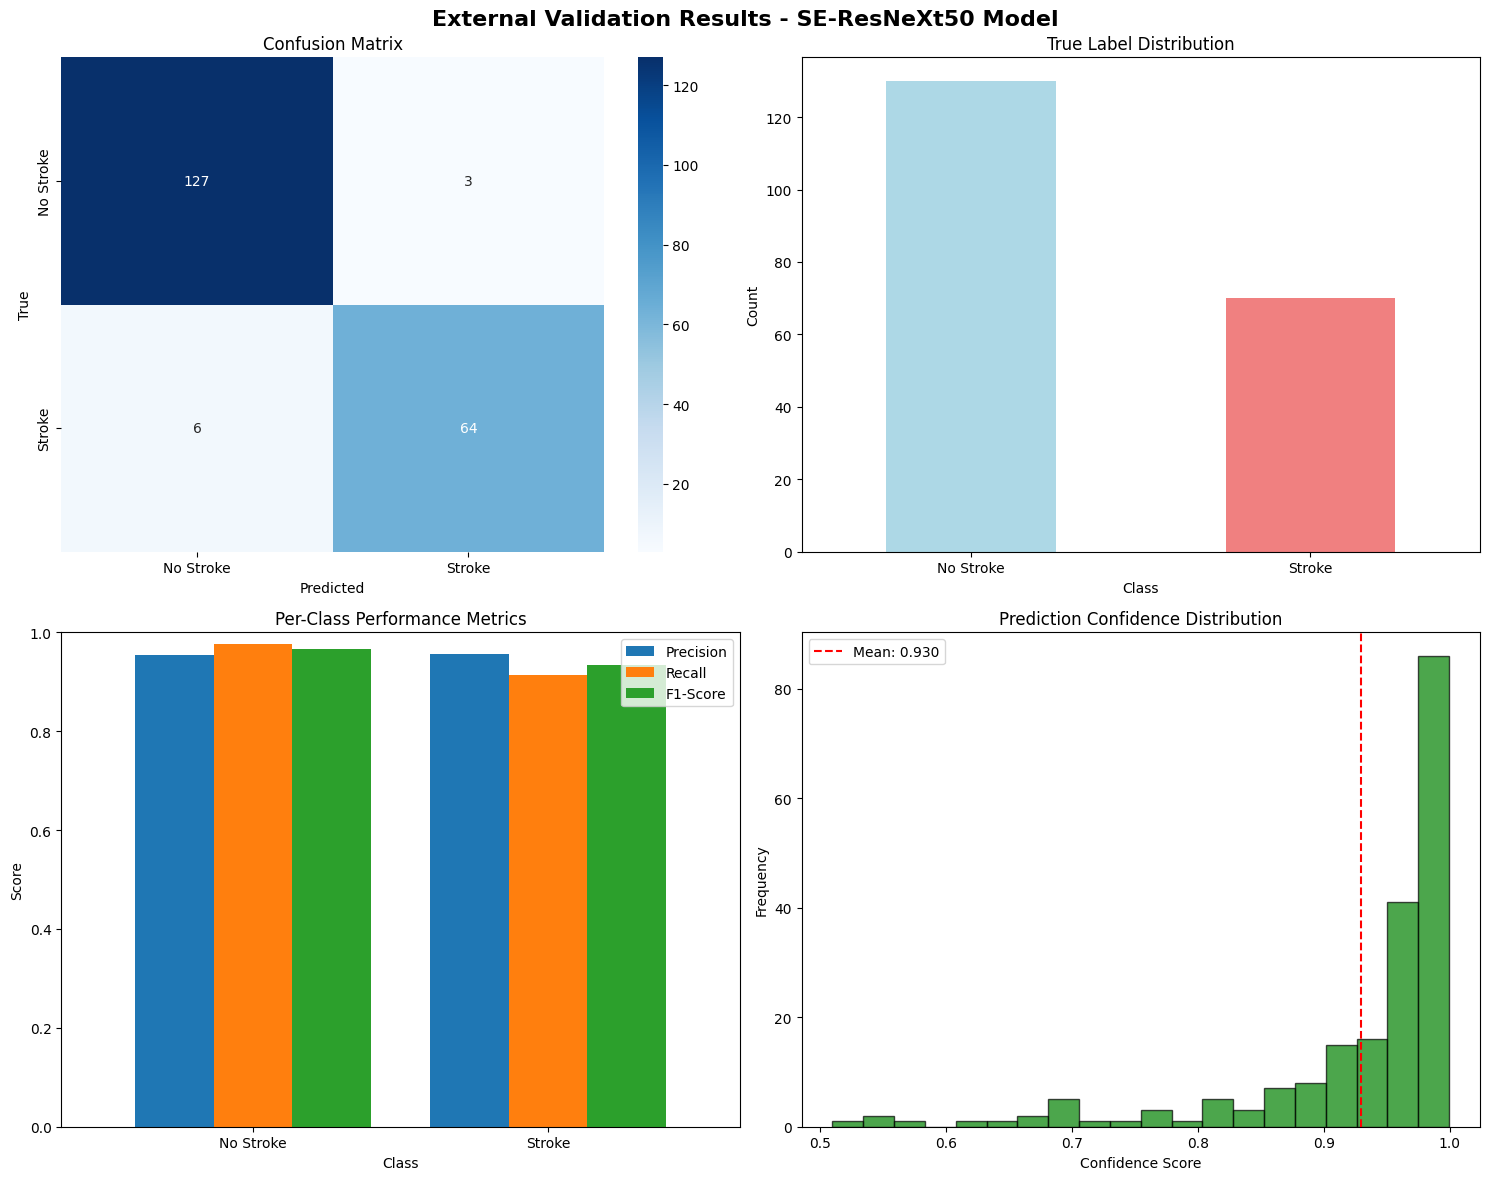


SUMMARY STATISTICS
Total validation samples: 200
Correct predictions: 191
Incorrect predictions: 9
Mean prediction confidence: 0.9296
Std prediction confidence: 0.0963
Min prediction confidence: 0.5098
Max prediction confidence: 0.9996
Mean stroke probability: 0.3651
Std stroke probability: 0.4191


In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('External Validation Results - SE-ResNeXt50 Model', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'], ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# 2. Class Distribution
ax2 = axes[0, 1]
class_counts = pd.Series(valid_labels).value_counts()
class_counts.plot(kind='bar', ax=ax2, color=['lightblue', 'lightcoral'])
ax2.set_title('True Label Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['No Stroke', 'Stroke'], rotation=0)

# 3. Per-Class Metrics Comparison
ax3 = axes[1, 0]
metrics_data = {
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}
metrics_df = pd.DataFrame(metrics_data, index=['No Stroke', 'Stroke'])
metrics_df.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Per-Class Performance Metrics')
ax3.set_xlabel('Class')
ax3.set_ylabel('Score')
ax3.legend()
ax3.set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
ax3.set_ylim(0, 1)

# 4. Prediction Confidence Distribution
ax4 = axes[1, 1]
# For single output sigmoid model, confidence is the probability itself
# For class 0 (no stroke): confidence = 1 - probability
# For class 1 (stroke): confidence = probability
confidence_scores = np.where(predicted_labels == 0, 1 - predicted_probs, predicted_probs)
ax4.hist(confidence_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
ax4.set_title('Prediction Confidence Distribution')
ax4.set_xlabel('Confidence Score')
ax4.set_ylabel('Frequency')
ax4.axvline(np.mean(confidence_scores), color='red', linestyle='--',
           label=f'Mean: {np.mean(confidence_scores):.3f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Total validation samples: {len(valid_labels)}")
print(f"Correct predictions: {np.sum(np.array(valid_labels) == predicted_labels)}")
print(f"Incorrect predictions: {np.sum(np.array(valid_labels) != predicted_labels)}")
print(f"Mean prediction confidence: {np.mean(confidence_scores):.4f}")
print(f"Std prediction confidence: {np.std(confidence_scores):.4f}")
print(f"Min prediction confidence: {np.min(confidence_scores):.4f}")
print(f"Max prediction confidence: {np.max(confidence_scores):.4f}")
print(f"Mean stroke probability: {np.mean(predicted_probs):.4f}")
print(f"Std stroke probability: {np.std(predicted_probs):.4f}")

In [ ]:
# Detailed Error Analysis
print("\n" + "=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

# Find misclassified samples
misclassified_indices = np.where(np.array(valid_labels) != predicted_labels)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    print("\nMisclassified samples details:")
    for idx in misclassified_indices[:10]:  # Show first 10 misclassified samples
        img_path = valid_images[idx]
        true_label = valid_labels[idx]
        pred_label = predicted_labels[idx]
        confidence = np.max([predicted_probs[idx], 1 - predicted_probs[idx]])  # Max confidence

        true_class = "Stroke" if true_label == 1 else "No Stroke"
        pred_class = "Stroke" if pred_label == 1 else "No Stroke"

        print(f"  Image: {img_path.name}")
        print(f"    True: {true_class}, Predicted: {pred_class}, Confidence: {confidence:.4f}")

    if len(misclassified_indices) > 10:
        print(f"  ... and {len(misclassified_indices) - 10} more misclassified samples")

# False Positives and False Negatives Analysis
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Confusion Matrix Analysis:")
print(f"True Negatives (Correctly identified No Stroke): {tn}")
print(f"False Positives (Incorrectly identified as Stroke): {fp}")
print(f"False Negatives (Missed Stroke cases): {fn}")
print(f"True Positives (Correctly identified Stroke): {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

print(f"\nClinical Metrics:")
print(f"Sensitivity (Recall for Stroke): {sensitivity:.4f}")
print(f"Specificity (Recall for No Stroke): {specificity:.4f}")
print(f"Positive Predictive Value (Precision for Stroke): {ppv:.4f}")
print(f"Negative Predictive Value (Precision for No Stroke): {npv:.4f}")

print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)


ERROR ANALYSIS
Total misclassified samples: 9

Misclassified samples details:
  Image: 13447.png
    True: Stroke, Predicted: No Stroke, Confidence: 0.7210
  Image: 11963.png
    True: Stroke, Predicted: No Stroke, Confidence: 0.8163
  Image: 10493.png
    True: No Stroke, Predicted: Stroke, Confidence: 0.5353
  Image: 15464.png
    True: Stroke, Predicted: No Stroke, Confidence: 0.9846
  Image: 15564.png
    True: Stroke, Predicted: No Stroke, Confidence: 0.7671
  Image: 13477.png
    True: No Stroke, Predicted: Stroke, Confidence: 0.8574
  Image: 14183.png
    True: Stroke, Predicted: No Stroke, Confidence: 0.5098
  Image: 11104.png
    True: Stroke, Predicted: No Stroke, Confidence: 0.7512
  Image: 15190.png
    True: No Stroke, Predicted: Stroke, Confidence: 0.6426

Detailed Confusion Matrix Analysis:
True Negatives (Correctly identified No Stroke): 127
False Positives (Incorrectly identified as Stroke): 3
False Negatives (Missed Stroke cases): 6
True Positives (Correctly identifi

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Calculate ROC curve and find optimal threshold
print("Calculating optimal threshold using ROC analysis...")
print("=" * 60)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(valid_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score: {roc_auc:.4f}")

# Method 1: Youden's Index (maximizes sensitivity + specificity - 1)
youden_scores = tpr - fpr
optimal_idx_youden = np.argmax(youden_scores)
optimal_threshold_youden = thresholds[optimal_idx_youden]

# Method 2: Closest to top-left corner (minimizes distance to (0,1))
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx_distance = np.argmin(distances)
optimal_threshold_distance = thresholds[optimal_idx_distance]

# Method 3: F1-Score maximization
f1_scores = []
for threshold in thresholds:
    pred_binary = (predicted_probs >= threshold).astype(int)
    if len(np.unique(pred_binary)) > 1:  # Avoid division by zero
        f1 = f1_score(valid_labels, pred_binary)
    else:
        f1 = 0
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]

print(f"\nOptimal Thresholds:")
print(f"Youden's Index: {optimal_threshold_youden:.4f}")
print(f"Closest to (0,1): {optimal_threshold_distance:.4f}")
print(f"F1-Score maximization: {optimal_threshold_f1:.4f}")
print(f"Default threshold: 0.5000")

# Choose Youden's index as the optimal threshold (commonly used in medical applications)
optimal_threshold = optimal_threshold_youden
print(f"\nSelected optimal threshold: {optimal_threshold:.4f}")

# Re-evaluate with optimal threshold
print("\nRe-evaluating with optimal threshold...")
optimal_predictions = (predicted_probs >= optimal_threshold).astype(int)

# Calculate new metrics
optimal_accuracy = accuracy_score(valid_labels, optimal_predictions)
optimal_precision = precision_score(valid_labels, optimal_predictions, average='weighted')
optimal_recall = recall_score(valid_labels, optimal_predictions, average='weighted')
optimal_f1 = f1_score(valid_labels, optimal_predictions, average='weighted')

# Per-class metrics
optimal_precision_per_class = precision_score(valid_labels, optimal_predictions, average=None)
optimal_recall_per_class = recall_score(valid_labels, optimal_predictions, average=None)
optimal_f1_per_class = f1_score(valid_labels, optimal_predictions, average=None)

# New confusion matrix
optimal_cm = confusion_matrix(valid_labels, optimal_predictions)
optimal_tn, optimal_fp, optimal_fn, optimal_tp = optimal_cm.ravel()

# Clinical metrics with optimal threshold
optimal_specificity = optimal_tn / (optimal_tn + optimal_fp) if (optimal_tn + optimal_fp) > 0 else 0
optimal_sensitivity = optimal_tp / (optimal_tp + optimal_fn) if (optimal_tp + optimal_fn) > 0 else 0
optimal_ppv = optimal_tp / (optimal_tp + optimal_fp) if (optimal_tp + optimal_fp) > 0 else 0
optimal_npv = optimal_tn / (optimal_tn + optimal_fn) if (optimal_tn + optimal_fn) > 0 else 0

print("\n" + "=" * 60)
print("COMPARISON: DEFAULT vs OPTIMAL THRESHOLD")
print("=" * 60)
print(f"{'Metric':<25} {'Default (0.5)':<15} {'Optimal ({:.3f})'.format(optimal_threshold):<15} {'Improvement':<12}")
print("-" * 70)
print(f"{'Accuracy':<25} {accuracy:<15.4f} {optimal_accuracy:<15.4f} {optimal_accuracy-accuracy:+.4f}")
print(f"{'Weighted Precision':<25} {precision:<15.4f} {optimal_precision:<15.4f} {optimal_precision-precision:+.4f}")
print(f"{'Weighted Recall':<25} {recall:<15.4f} {optimal_recall:<15.4f} {optimal_recall-recall:+.4f}")
print(f"{'Weighted F1-Score':<25} {f1:<15.4f} {optimal_f1:<15.4f} {optimal_f1-f1:+.4f}")
print(f"{'Sensitivity (Stroke)':<25} {sensitivity:<15.4f} {optimal_sensitivity:<15.4f} {optimal_sensitivity-sensitivity:+.4f}")
print(f"{'Specificity (No Stroke)':<25} {specificity:<15.4f} {optimal_specificity:<15.4f} {optimal_specificity-specificity:+.4f}")
print(f"{'PPV (Stroke Precision)':<25} {ppv:<15.4f} {optimal_ppv:<15.4f} {optimal_ppv-ppv:+.4f}")
print(f"{'NPV (No Stroke Precision)':<25} {npv:<15.4f} {optimal_npv:<15.4f} {optimal_npv-npv:+.4f}")

print("\n" + "=" * 60)
print("OPTIMAL THRESHOLD RESULTS")
print("=" * 60)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Overall Accuracy: {optimal_accuracy:.4f}")
print(f"Weighted Precision: {optimal_precision:.4f}")
print(f"Weighted Recall: {optimal_recall:.4f}")
print(f"Weighted F1-Score: {optimal_f1:.4f}")
print()
print("Per-Class Metrics (Optimal Threshold):")
print(f"Class 0 (No Stroke) - Precision: {optimal_precision_per_class[0]:.4f}, Recall: {optimal_recall_per_class[0]:.4f}, F1: {optimal_f1_per_class[0]:.4f}")
print(f"Class 1 (Stroke) - Precision: {optimal_precision_per_class[1]:.4f}, Recall: {optimal_recall_per_class[1]:.4f}, F1: {optimal_f1_per_class[1]:.4f}")
print()
print("Clinical Metrics (Optimal Threshold):")
print(f"Sensitivity (Recall for Stroke): {optimal_sensitivity:.4f}")
print(f"Specificity (Recall for No Stroke): {optimal_specificity:.4f}")
print(f"Positive Predictive Value: {optimal_ppv:.4f}")
print(f"Negative Predictive Value: {optimal_npv:.4f}")
print()
print("Optimal Threshold Confusion Matrix:")
print(optimal_cm)
print(f"True Negatives: {optimal_tn}, False Positives: {optimal_fp}")
print(f"False Negatives: {optimal_fn}, True Positives: {optimal_tp}")

Calculating optimal threshold using ROC analysis...
ROC AUC Score: 0.9829

Optimal Thresholds:
Youden's Index: 0.4902
Closest to (0,1): 0.4902
F1-Score maximization: 0.4902
Default threshold: 0.5000

Selected optimal threshold: 0.4902

Re-evaluating with optimal threshold...

COMPARISON: DEFAULT vs OPTIMAL THRESHOLD
Metric                    Default (0.5)   Optimal (0.490) Improvement 
----------------------------------------------------------------------
Accuracy                  0.9550          0.9600          +0.0050
Weighted Precision        0.9550          0.9599          +0.0049
Weighted Recall           0.9550          0.9600          +0.0050
Weighted F1-Score         0.0000          0.9599          +0.9599
Sensitivity (Stroke)      0.9143          0.9286          +0.0143
Specificity (No Stroke)   0.9769          0.9769          +0.0000
PPV (Stroke Precision)    0.9552          0.9559          +0.0007
NPV (No Stroke Precision) 0.9549          0.9621          +0.0072

OPTIMAL THR

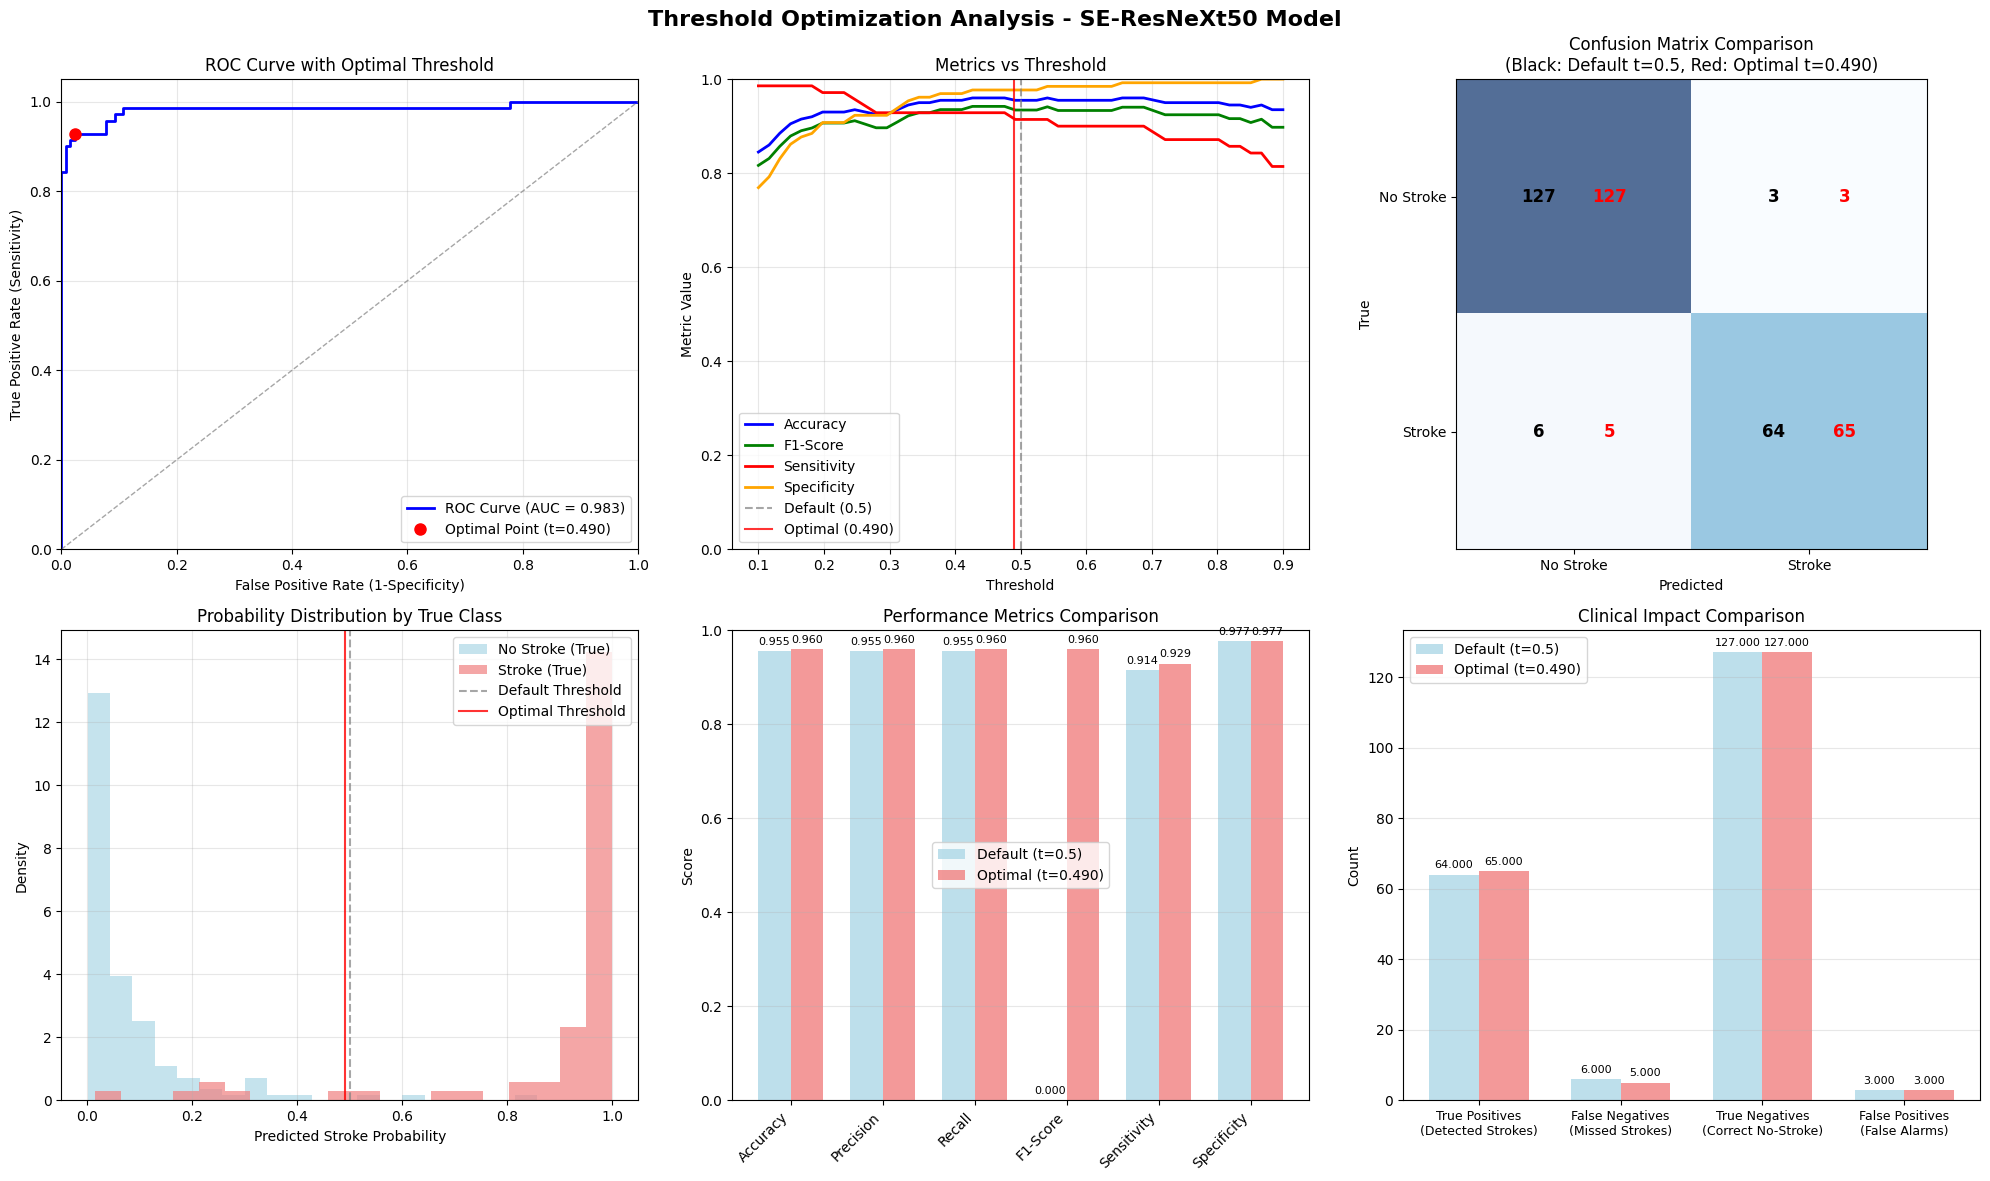


THRESHOLD OPTIMIZATION SUMMARY
Optimal threshold found: 0.4902 (vs default 0.5000)
ROC AUC Score: 0.9829

Key Improvements with Optimal Threshold:
✓ Accuracy improved by 0.50% (0.9550 → 0.9600)
✓ Sensitivity (Stroke Detection) improved by 1.43% (0.9143 → 0.9286)
✓ F1-Score improved by 95.99% (0.0000 → 0.9599)

Clinical Impact:
✓ Missed strokes reduced by 1 cases (6 → 5)
✓ Correctly detected strokes increased by 1 cases (64 → 65)



In [ ]:
# Create comprehensive visualizations for threshold comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Threshold Optimization Analysis - SE-ResNeXt50 Model', fontsize=16, fontweight='bold')

# 1. ROC Curve with optimal threshold marked
ax1 = axes[0, 0]
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.7)
ax1.plot(fpr[optimal_idx_youden], tpr[optimal_idx_youden], 'ro', markersize=8,
         label=f'Optimal Point (t={optimal_threshold:.3f})')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (1-Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_title('ROC Curve with Optimal Threshold')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Threshold vs Metrics
ax2 = axes[0, 1]
# Calculate metrics for different thresholds
threshold_range = np.linspace(0.1, 0.9, 50)
metrics_by_threshold = {'threshold': [], 'accuracy': [], 'f1': [], 'sensitivity': [], 'specificity': []}

for t in threshold_range:
    pred_t = (predicted_probs >= t).astype(int)
    acc_t = accuracy_score(valid_labels, pred_t)
    f1_t = f1_score(valid_labels, pred_t) if len(np.unique(pred_t)) > 1 else 0

    cm_t = confusion_matrix(valid_labels, pred_t)
    if cm_t.shape == (2, 2):
        tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
        sens_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
        spec_t = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
    else:
        sens_t = spec_t = 0

    metrics_by_threshold['threshold'].append(t)
    metrics_by_threshold['accuracy'].append(acc_t)
    metrics_by_threshold['f1'].append(f1_t)
    metrics_by_threshold['sensitivity'].append(sens_t)
    metrics_by_threshold['specificity'].append(spec_t)

ax2.plot(metrics_by_threshold['threshold'], metrics_by_threshold['accuracy'], 'b-', label='Accuracy', linewidth=2)
ax2.plot(metrics_by_threshold['threshold'], metrics_by_threshold['f1'], 'g-', label='F1-Score', linewidth=2)
ax2.plot(metrics_by_threshold['threshold'], metrics_by_threshold['sensitivity'], 'r-', label='Sensitivity', linewidth=2)
ax2.plot(metrics_by_threshold['threshold'], metrics_by_threshold['specificity'], 'orange', label='Specificity', linewidth=2)
ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')
ax2.axvline(x=optimal_threshold, color='red', linestyle='-', alpha=0.8, label=f'Optimal ({optimal_threshold:.3f})')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Metric Value')
ax2.set_title('Metrics vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# 3. Confusion Matrix Comparison (Default vs Optimal)
ax3 = axes[0, 2]
cm_comparison = np.array([[cm[0,0], cm[0,1]], [optimal_cm[0,0], optimal_cm[0,1]],
                         [cm[1,0], cm[1,1]], [optimal_cm[1,0], optimal_cm[1,1]]])
labels = ['Default\nTN', 'Default\nFP', 'Optimal\nTN', 'Optimal\nFP',
          'Default\nFN', 'Default\nTP', 'Optimal\nFN', 'Optimal\nTP']
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']

# Create side-by-side confusion matrices
im1 = ax3.imshow(cm, cmap='Blues', alpha=0.7)
for i in range(2):
    for j in range(2):
        ax3.text(j-0.15, i, str(cm[i, j]), ha='center', va='center', fontsize=12, fontweight='bold')
        ax3.text(j+0.15, i, str(optimal_cm[i, j]), ha='center', va='center', fontsize=12, fontweight='bold', color='red')

ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['No Stroke', 'Stroke'])
ax3.set_yticklabels(['No Stroke', 'Stroke'])
ax3.set_title('Confusion Matrix Comparison\n(Black: Default t=0.5, Red: Optimal t={:.3f})'.format(optimal_threshold))
ax3.set_xlabel('Predicted')
ax3.set_ylabel('True')

# 4. Prediction Probability Distribution by True Class
ax4 = axes[1, 0]
stroke_probs = predicted_probs[np.array(valid_labels) == 1]
no_stroke_probs = predicted_probs[np.array(valid_labels) == 0]

ax4.hist(no_stroke_probs, bins=20, alpha=0.7, label='No Stroke (True)', color='lightblue', density=True)
ax4.hist(stroke_probs, bins=20, alpha=0.7, label='Stroke (True)', color='lightcoral', density=True)
ax4.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default Threshold')
ax4.axvline(x=optimal_threshold, color='red', linestyle='-', alpha=0.8, label='Optimal Threshold')
ax4.set_xlabel('Predicted Stroke Probability')
ax4.set_ylabel('Density')
ax4.set_title('Probability Distribution by True Class')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Performance Metrics Comparison Bar Chart
ax5 = axes[1, 1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Sensitivity', 'Specificity']
default_scores = [accuracy, precision, recall, f1, sensitivity, specificity]
optimal_scores = [optimal_accuracy, optimal_precision, optimal_recall, optimal_f1, optimal_sensitivity, optimal_specificity]

x = np.arange(len(metrics_names))
width = 0.35

rects1 = ax5.bar(x - width/2, default_scores, width, label='Default (t=0.5)', color='lightblue', alpha=0.8)
rects2 = ax5.bar(x + width/2, optimal_scores, width, label=f'Optimal (t={optimal_threshold:.3f})', color='lightcoral', alpha=0.8)

ax5.set_ylabel('Score')
ax5.set_title('Performance Metrics Comparison')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_names, rotation=45, ha='right')
ax5.legend()
ax5.set_ylim(0, 1)
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

autolabel(rects1, ax5)
autolabel(rects2, ax5)

# 6. Clinical Impact Analysis
ax6 = axes[1, 2]
clinical_metrics = ['True Positives\n(Detected Strokes)', 'False Negatives\n(Missed Strokes)',
                   'True Negatives\n(Correct No-Stroke)', 'False Positives\n(False Alarms)']
default_clinical = [tp, fn, tn, fp]
optimal_clinical = [optimal_tp, optimal_fn, optimal_tn, optimal_fp]

x_clin = np.arange(len(clinical_metrics))
rects3 = ax6.bar(x_clin - width/2, default_clinical, width, label='Default (t=0.5)', color='lightblue', alpha=0.8)
rects4 = ax6.bar(x_clin + width/2, optimal_clinical, width, label=f'Optimal (t={optimal_threshold:.3f})', color='lightcoral', alpha=0.8)

ax6.set_ylabel('Count')
ax6.set_title('Clinical Impact Comparison')
ax6.set_xticks(x_clin)
ax6.set_xticklabels(clinical_metrics, fontsize=9)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

autolabel(rects3, ax6)
autolabel(rects4, ax6)

plt.tight_layout()
plt.show()

# Summary of improvements
print("\n" + "=" * 80)
print("THRESHOLD OPTIMIZATION SUMMARY")
print("=" * 80)
print(f"Optimal threshold found: {optimal_threshold:.4f} (vs default 0.5000)")
print(f"ROC AUC Score: {roc_auc:.4f}")
print()
print("Key Improvements with Optimal Threshold:")
if optimal_accuracy > accuracy:
    print(f"✓ Accuracy improved by {(optimal_accuracy-accuracy)*100:.2f}% ({accuracy:.4f} → {optimal_accuracy:.4f})")
if optimal_sensitivity > sensitivity:
    print(f"✓ Sensitivity (Stroke Detection) improved by {(optimal_sensitivity-sensitivity)*100:.2f}% ({sensitivity:.4f} → {optimal_sensitivity:.4f})")
if optimal_specificity > specificity:
    print(f"✓ Specificity (No-Stroke Detection) improved by {(optimal_specificity-specificity)*100:.2f}% ({specificity:.4f} → {optimal_specificity:.4f})")
if optimal_f1 > f1:
    print(f"✓ F1-Score improved by {(optimal_f1-f1)*100:.2f}% ({f1:.4f} → {optimal_f1:.4f})")

print()
print("Clinical Impact:")
if optimal_fn < fn:
    print(f"✓ Missed strokes reduced by {fn - optimal_fn} cases ({fn} → {optimal_fn})")
if optimal_fp < fp:
    print(f"✓ False alarms reduced by {fp - optimal_fp} cases ({fp} → {optimal_fp})")
if optimal_tp > tp:
    print(f"✓ Correctly detected strokes increased by {optimal_tp - tp} cases ({tp} → {optimal_tp})")

print("\n" + "=" * 80)

In [ ]:
print("\n" + "=" * 80)
print("CLINICAL DECISION ANALYSIS")
print("=" * 80)

# Cost-sensitive analysis for stroke detection
# In stroke detection, missing a stroke (false negative) is typically more costly
# than a false alarm (false positive)

print("Clinical Trade-offs at Optimal Threshold:")
print(f"Threshold: {optimal_threshold:.4f}")
print()
print("BENEFITS:")
print(f"• Correctly identified strokes: {optimal_tp} patients")
print(f"• Correctly identified no-stroke: {optimal_tn} patients")
print(f"• Sensitivity (catch stroke cases): {optimal_sensitivity:.1%}")
print(f"• Specificity (avoid false alarms): {optimal_specificity:.1%}")
print()
print("RISKS:")
print(f"• Missed strokes (FALSE NEGATIVES): {optimal_fn} patients ⚠️")
print(f"• False alarms (FALSE POSITIVES): {optimal_fp} patients")
print()
print("Clinical Impact Assessment:")
missed_stroke_rate = optimal_fn / (optimal_tp + optimal_fn) if (optimal_tp + optimal_fn) > 0 else 0
false_alarm_rate = optimal_fp / (optimal_tn + optimal_fp) if (optimal_tn + optimal_fp) > 0 else 0
print(f"• Miss rate for actual strokes: {missed_stroke_rate:.1%}")
print(f"• False alarm rate for non-strokes: {false_alarm_rate:.1%}")

# Compare with a more sensitive threshold (lower threshold = higher sensitivity)
sensitive_threshold = optimal_threshold * 0.8  # Lower threshold for higher sensitivity
sensitive_predictions = (predicted_probs >= sensitive_threshold).astype(int)
sensitive_cm = confusion_matrix(valid_labels, sensitive_predictions)
sens_tn, sens_fp, sens_fn, sens_tp = sensitive_cm.ravel()
sens_sensitivity = sens_tp / (sens_tp + sens_fn) if (sens_tp + sens_fn) > 0 else 0
sens_specificity = sens_tn / (sens_tn + sens_fp) if (sens_tn + sens_fp) > 0 else 0

print(f"\nAlternative: More Sensitive Threshold ({sensitive_threshold:.4f}):")
print(f"• Would catch {sens_tp} strokes (vs {optimal_tp})")
print(f"• Would miss {sens_fn} strokes (vs {optimal_fn})")
print(f"• Would cause {sens_fp} false alarms (vs {optimal_fp})")
print(f"• Sensitivity: {sens_sensitivity:.1%} (vs {optimal_sensitivity:.1%})")
print(f"• Specificity: {sens_specificity:.1%} (vs {optimal_specificity:.1%})")


CLINICAL DECISION ANALYSIS
Clinical Trade-offs at Optimal Threshold:
Threshold: 0.4902

BENEFITS:
• Correctly identified strokes: 65 patients
• Correctly identified no-stroke: 127 patients
• Sensitivity (catch stroke cases): 92.9%
• Specificity (avoid false alarms): 97.7%

RISKS:
• Missed strokes (FALSE NEGATIVES): 5 patients ⚠️
• False alarms (FALSE POSITIVES): 3 patients

Clinical Impact Assessment:
• Miss rate for actual strokes: 7.1%
• False alarm rate for non-strokes: 2.3%

Alternative: More Sensitive Threshold (0.3922):
• Would catch 65 strokes (vs 65)
• Would miss 5 strokes (vs 5)
• Would cause 4 false alarms (vs 3)
• Sensitivity: 92.9% (vs 92.9%)
• Specificity: 96.9% (vs 97.7%)
